## Vehicle Detection Project

### ~ Nalin Yatin Raut

In [67]:
"""  All imports """

import sys
path = '/opt/ros/kinetic/lib/python2.7/dist-packages'
if path in sys.path:
    print('Existing interference cleared')
    sys.path.remove(path)

import cv2
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.image as mpimg
from mpl_toolkits.mplot3d import Axes3D
from skimage.feature import hog
import skvideo.io


import glob
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pickle

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from scipy.ndimage.measurements import label


In [68]:
class Data():
    """
        class that processes data
    """
    def __init__(self):
        self.path = None
        self.train = None
        
    def load(self, directory = ".", illustrate = False):
        """
            using GLOB all the directories are searched for 
            required images and list of paths are updated
        """
        
        
        self.path = directory
        self.test_images = glob.glob("./test_images/*.jpg")
        self.vehicles = glob.glob("./vehicles/**/*.png")
        self.non_vehicles = glob.glob("./non-vehicles/**/*.png")
        
        

        print("[test_images] {}".format(len(self.test_images)))
        print("[vehicles] {}".format(len(self.vehicles)))
        print("[non_vehicles] {}".format(len(self.non_vehicles)))
        
        if illustrate == True:
            for i in range (3):
                
                vehicle = mpimg.imread(self.vehicles[i])
                non_vehicle = mpimg.imread(self.non_vehicles[i])
                
                
                fig = plt.figure()
                fig.set_figheight(5)
                fig.set_figwidth(5)
                plt.subplot(1,2,1)
                plt.imshow(vehicle)
                plt.axis('off')
                plt.title('Vehicle')
                plt.subplot(1,2,2)
                plt.imshow(non_vehicle)
                plt.axis('off')
                plt.title('Non Vehicle')
                
        
    def getData(self, _features, labels):
        
        """
            The car and non-car data is loaded here and split into
            train and test data. The scalar fit during this process is   
        """
        self.X_scaler = StandardScaler().fit(_features)
        scaled_X = self.X_scaler.transform(_features)

        pickle.dump(self.X_scaler, open('X_scaler.pkl', 'wb'))

        X_train, X_test, y_train, y_test = train_test_split(scaled_X, labels,
                                                            test_size=0.2)
        print('[Training data]{} [Training labels]{}'.format(X_train.shape, 
                                                            y_train.shape))
        print('[Test data]{} [Test labels]{}'.format(X_test.shape, 
                                                    y_test.shape))
        return (X_train, X_test, y_train, y_test)
    
    
    def load_scalar(self):
        self.X_scaler = pickle.load(open('X_scaler.pkl', 'rb'))

    def scale_vector(self,vector):
        return self.X_scaler.transform(vector)
    

[test_images] 6
[vehicles] 8792
[non_vehicles] 8968


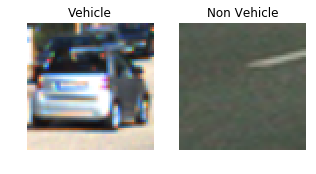

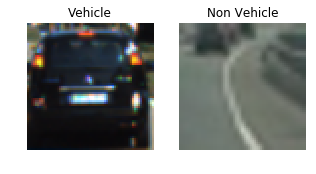

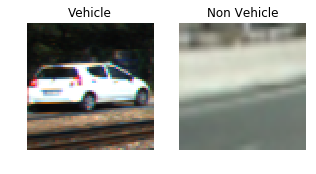

In [69]:
#ILLUSTRATION CELL - VEHICLE AND NON VEHICLE DATA
data = Data()
data.load(directory = ".", illustrate = True)

In [70]:

class FeatureExtractor():
    
    """ Class for feature extraction. Color, Spatial and HOG feature extraction."""
    
    def __init__(self):
        
        
        self.color_space = cv2.COLOR_RGB2YCrCb
        self.orientations = 16
        self.pixels_per_cell = (12,12)
        self.cells_per_block = (2,2)
        self.image_size = (32,32)
        self.color_feat_size = (64,64)
        self.bins = 32
        self.old_heatmap = None

        self.colorFeatures = False
        self.spatialFeatures = False
        self.HOGFeatures = True
        
    def colorspaceChange(self, image):
        return cv2.cvtColor(image,self.color_space)
    
    def getColorFeatures(self, image):
        """
            Computes histogram for each channel of image and 
            returns stacked feature vector of all 3 channels
        """
        ch1_hist = np.histogram(image[:, :, 0], bins=self.bins)
        ch2_hist = np.histogram(image[:, :, 1], bins=self.bins)
        ch3_hist = np.histogram(image[:, :, 2], bins=self.bins)
        return np.concatenate((ch1_hist[0], ch2_hist[0], ch3_hist[0]))
    
    def getSpatialFeatures(self, image):
        """
            flattens the given channel of the image
            returns stacked feature vector of all 3 channels
        """
        ch1_featr = image[:,:,0].ravel()
        ch2_featr = image[:,:,1].ravel()
        ch3_featr = image[:,:,2].ravel()

        return np.hstack((ch1_featr, ch2_featr, ch3_featr))
    
    def getHOGFeatures(self,image):
        """
            HOG of every channel of given image is computed and
            is concatenated to form one single feature vector
        """
        HOG_ch1 = hog(image[:,:,0], 
                            orientations= self.orientations , 
                            pixels_per_cell= self.pixels_per_cell , 
                            cells_per_block= self.cells_per_block,
                            visualise=False)
        HOG_ch2 = hog(image[:,:,1], 
                            orientations= self.orientations , 
                            pixels_per_cell= self.pixels_per_cell , 
                            cells_per_block= self.cells_per_block,
                            visualise=False)
        HOG_ch3 = hog(image[:,:,2], 
                            orientations= self.orientations , 
                            pixels_per_cell= self.pixels_per_cell , 
                            cells_per_block= self.cells_per_block,
                            visualise=False)
        return np.concatenate((HOG_ch1, HOG_ch2, HOG_ch3))
    
    
    def getHeatmap(self,image, bboxes,threshold=2):
        """
            A heatmap of image is created and heat is added in the region 
            covered by individual bounding box. Threshold is then applied 
            and outliers are removed
        """
        heat_map = np.zeros((image.shape[0],image.shape[1]))
        for bbox in bboxes:
            heat_map[bbox[0][1]:bbox[1][1], bbox[0][0]:bbox[1][0]]+=1
        
        # adding previous heatmap is like tracking the object
        if self.old_heatmap is not None:
            heat_map += 0.99*threshold*self.old_heatmap
        heat_map[heat_map <= threshold] = 0
        heat_map[heat_map > threshold] = 1
        self.old_heatmap = heat_map
        return heat_map
    
    
    def getFeatures(self, image):
        """
            All feature of the image are computed here and
            are concatenated to form a single feature vector
        """
        img = np.copy(image)
        img = cv2.resize(img, self.image_size)
        img = self.colorspaceChange(img) 

        Features = []
        
        if self.spatialFeatures:
            spatial_hist = self.getSpatialFeatures(img)
            Features.append(spatial_hist)
        
        if self.colorFeatures:    
            color_hist = self.getColorFeatures(img)
            Features.append(color_hist)
        
        if self.HOGFeatures:    
            hog_hist = self.getHOGFeatures(img)
            Features.append(hog_hist)

        features = np.concatenate((Features))
        return features

In [71]:
class Classifier():
    """
        Classifier model which is used to classify the feature vector 
        into car and non-car
    """
    def __init__(self):
        self.clf = RandomForestClassifier(
            n_estimators=150, max_features="auto", min_samples_leaf=4)

    def train(self, X_train, y_train, X_test, y_test):
        self.clf.fit(X_train, y_train)
        print("[accuracy] {}".format(self.clf.score(X_test, y_test)))
        self.save()

    def predict(self, inputX):
        pred_proba = self.clf.predict_proba(inputX)
        return pred_proba

    def save(self):
        pickle.dump(self.clf, open('random_forrest_model.p', 'wb'))
        print("[INFO] classifier saved")

    def load(self):
        self.clf = pickle.load(open('random_forrest_model.p', 'rb'))
    

In [72]:
class Visualize():
    """
        This class takes care of drawing bounding boxes over images
    """
    RED     = (255, 0,  0)
    GREEN   = (0,   255,0)
    BLUE    = (0,   0,  255)
    CYAN    = (0,   255,255)
    YELLOW  = (255, 255,0)
    MAGENTA = (255, 0,  255)

    COLORS  = [RED,GREEN,BLUE,CYAN,YELLOW,MAGENTA]
    
    def __init__(self):
        self.line_thickness = 1
    
    def draw_bounding_box(self, image, bboxes, color=YELLOW):
        bb_image = np.copy(image)
        for bbox in bboxes:
            cv2.rectangle(bb_image, bbox[0], bbox[1], 
                            color, self.line_thickness)
        return bb_image

    def draw_labeled_bounding_box(self,image,labels):
        """
            code used from lessons
        """
        for car in range(1,labels[1]+1):
            nonzero = (labels[0] == car).nonzero()
            # Identify x and y values of those pixels
            nonzeroy = np.array(nonzero[0])
            nonzerox = np.array(nonzero[1])
            # Define a bounding box based on min/max x and y
            bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
            # Draw the box on the image
            height, width,_ = image.shape
            if (bbox[0][0]>0.45*width) and (bbox[0][1]>0.45*height):
                cv2.rectangle(image, bbox[0], bbox[1], self.GREEN, self.line_thickness+5)
            # Return the image
        return image

In [73]:

class TrackVehicle():
    
    """ 
        Pipeline for vehicle tracking 
    """
    
    def __init__(self):
        print("Vehicle Detector")
        self.data = Data()
        self.data.load(directory = '.')
        self.features = FeatureExtractor()
        self.clf = Classifier()
        self.visualize = Visualize()
        
        #self.clf.load()
        #self.data.load_scalar()

        self.probability_threshold = 0.6
        
    def getDataset(self):
        """
            Prepares data of CAR and NON-CAR for training The classifier
        """
        self.feat = []
        self.labels = []
        total_files = len(self.data.vehicles)+len(self.data.non_vehicles)
        count = 0
        
        for vehicle_file in self.data.vehicles:
            #self.printProgressBar(count, total_files, prefix='Progress', suffix='Complete', length=50)
            # print(vehicle_file)
            image = cv2.imread(vehicle_file)
            feature = self.features.getFeatures(image)
            self.feat.append(feature)
            self.labels.append([1])
            count += 1
            
        for non_vehicle_file in self.data.non_vehicles:
            #self.printProgressBar(count, total_files, prefix='Progress',suffix='Complete', length=50)
            image = cv2.imread(non_vehicle_file)
            feature = self.features.getFeatures(image)
            self.feat.append(feature)
            self.labels.append([0])
            count += 1

        self.feat = np.vstack(self.feat).astype(np.float64)
        self.labels = np.array(self.labels)
        
        
#         combined = self.data.vehicles + self.data.non_vehicles
        
#         X_scaler = StandardScaler().fit(self.feat)
        
#         # Apply the scaler to X
#         scaled_X = X_scaler.transform(self.feat)
#         ind = np.random.randint(0, total_files)
                                    
        # Plot an example of raw and scaled features
#         fig = plt.figure(figsize=(12,4))
#         plt.subplot(131)
#         plt.imshow(mpimg.imread(combined[0]))
#         plt.title('Original Image')
#         plt.subplot(132)
#         plt.plot(self.feat[0])
#         plt.title('Raw Features')
#         plt.subplot(133)
#         plt.plot(scaled_X[0])
#         plt.title('Normalized Features')
#         fig.tight_layout()

        print("[features size]{} [labels size]{} ".format(
            self.feat.shape, self.labels.shape))

        X_train, X_test, y_train, y_test = self.data.getData(
            self.feat, self.labels)
        
        self.clf.train(X_train, y_train, X_test, y_test)
        
        
        
        
        
    def slide_window(self,img, x_span=[None, None], y_span=[None, None], 
                        xy_window=(32, 32), xy_overlap=(0.5, 0.5)):
        """
            code used from lessons
        """
        self.image = img
        
        # If x and/or y start/stop positions not defined, set to image size
        if x_span[0] == None:
            x_span[0] = 0
        if x_span[1] == None:
            x_span[1] = self.image.shape[1]
        if y_span[0] == None:
            y_span[0] = 0
        if y_span[1] == None:
            y_span[1] = self.image.shape[0]
            
        # Compute the span of the region to be searched    
        xspan = x_span[1] - x_span[0]
        yspan = y_span[1] - y_span[0]
        
        
        # Compute the number of pixels per step in x/y
        nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
        ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
        
    
        # Compute the number of windows in x/y
        nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
        ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
        
        nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
        ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
        
        # Initialize a list to append window positions to
        window_list = []
        # Loop through finding x and y window positions
        # Note: you could vectorize this step, but in practice
        # you'll be considering windows one by one with your
        # classifier, so looping makes sense
        for ys in range(ny_windows):
            for xs in range(nx_windows):
                # Calculate window position
                startx = xs*nx_pix_per_step + x_span[0]
                endx = startx + xy_window[0]
                starty = ys*ny_pix_per_step + y_span[0]
                endy = starty + xy_window[1]
                # Append window position to list
                window_list.append(((startx, starty), (endx, endy)))
        # Return the list of windows
        return window_list
    
    
    
    def get_windows(self,image):
        """
            pre-defined window sizes
        """
        window_image = np.copy(image)
        height, width,_ = window_image.shape

        # print(width,height)
        scale_factors = [
                        (0.4,1.0,0.55,0.8,64),
                        (0.4,1.0,0.55,0.8,96),
                        (0.4,1.0,0.55,0.9,128),
                        (0.4,1.0,0.55,0.9,140),
                        (0.4,1.0,0.55,0.9,160),
                        (0.4,1.0,0.50,0.9,192)]

        windows = list()
        for scale_factor in scale_factors:
            window_1 = self.slide_window(window_image,
                            x_span=[int(scale_factor[0]*width), 
                                            int(scale_factor[1]*width)], 
                            y_span=[int(scale_factor[2]*height), 
                                            int(scale_factor[3]*height)],
                            
                            xy_window=( scale_factor[4], 
                                        scale_factor[4]), 
                            xy_overlap=(0.5, 0.5))
            windows.append(window_1)
        

        return windows
    
    def process_image(self,image,visualization=None):
        process_image = np.copy(image)
        viz_image = np.copy(image)
        plt.figure()
        windows = self.get_windows(image)

        cells = []
        all_X = []
        for window in windows:
            for cell in window:
                try:
                    image_roi = process_image[cell[0][1]:cell[1][1], cell[0][0]:cell[1][0]]
                    
                    if sum(image_roi.shape)-sum((32,32,3)) > 0:
                        X = self.features.getFeatures(image_roi)
                        all_X.append(X)
                        cells.append(cell)
                        
                except cv2.error as e:
                    # print(e)
                    pass
        features = np.vstack(all_X).astype(np.float64)
        features = self.data.scale_vector(features)
        pred_proba = self.clf.predict(features)
        final_bbox = []
        for i,_pred in enumerate(pred_proba):
            if _pred[1] > self.probability_threshold:
                viz_image = self.visualize.draw_bounding_box(viz_image,[cells[i]],color=self.visualize.GREEN)
                final_bbox.append(cells[i])

        heat_map = self.features.getHeatmap(image, final_bbox)
        labels = label(heat_map)
        final_img = self.visualize.draw_labeled_bounding_box(image,labels)
        
        if visualization is not None:
            return final_img,heat_map,viz_image
        return final_img
    
    
    def printProgressBar(iteration, total, prefix, suffix, decimals=1, length=100, fill='█'):
    
        percent = ("{0:."+str(decimals)+"f}").format(100 * (iteration / float(total)))
        filledLength = int(length * iteration // total)
        bar = fill * filledLength + '-' * (length - filledLength)
        print('\r%s |%s| %s%% %s' % (prefix, bar, percent, suffix), end='\r')
        # Print New Line on Complete
        if percent == 100.0:
            print()

    

In [80]:
class Process():
    
    def __init__(self):
        
        self.detect = TrackVehicle()
        
        self.detect.getDataset()
        self.data = Data()
        self.data.load()
        
        self.features = FeatureExtractor()
        self.visualize = Visualize()
        
    
    def test_features(self):
        from skimage.feature import hog
        img = cv2.imread(data.vehicles[0])
        
        feat_ch1,out_img = hog(img[:,:,0], 
                                orientations= 16 , 
                                pixels_per_cell= (12,12) , 
                                cells_per_block= (2,2),
                                visualise=True)
        
        fig = plt.figure()
        fig.set_figheight(10)
        fig.set_figwidth(10)
        
        plt.subplot(1,3,1)
        plt.imshow(img)
        plt.title("Original image")
        plt.axis("off")
        
        plt.subplot(1,3,2)
        plt.imshow(self.features.colorspaceChange(img))
        plt.title("YCrCb")
        plt.axis("off")
        
       
        plt.subplot(1,3,3)
        plt.imshow(out_img)
        plt.title("Hog features")
        plt.axis("off")
        
        
        fig1 = plt.figure()
        fig.set_figheight(15)
        fig.set_figwidth(15)
        plt.plot(self.features.getFeatures(img))
        plt.title("Feature Vector")
   
        
        
       
        
        
    def test_windows(self):
        for img_file in data.test_images:
            img = cv2.imread(img_file)
            windows = self.detect.get_windows(img)
            plt.figure()
            processed_img = np.copy(img)
            for idx,window in enumerate(windows):
                processed_img = self.visualize.draw_bounding_box(processed_img,window,color=self.visualize.COLORS[idx])

            plt.imshow(processed_img)
            plt.show()
            
            
    def test_car_detection(self):
        for img_file in data.test_images:
            img = cv2.imread(img_file)
            final_img,heat_map,viz_img = self.detect.process_image(img,visualization=True)
       
            
            fig = plt.figure()
            fig.set_figheight(10)
            fig.set_figwidth(10)

            
            
            plt.subplot(1,3,1)
            plt.imshow(viz_img)
            plt.title("Windows")
            plt.axis("off")
            
            plt.subplot(1,3,2)
            plt.imshow(heat_map,cmap='gray')
            plt.title("Binary Heatmap")
            plt.axis("off")
            
            plt.subplot(1,3,3)
            plt.imshow(final_img)
            plt.title("Image")
            plt.axis("off")


         
          
            
    def train_pipeline(self):
        self.detect.getDataset()
        
     
    def process_video(self):
        video = "project_video.mp4"
        output_video = "project_video_output.mp4"
        writer = skvideo.io.FFmpegWriter(output_video)
        videogen = skvideo.io.vreader(video)#skvideo.datasets.bigbuckbunny())
        for frame in videogen:
            final_img = self.detect.process_image(frame)
            writer.writeFrame(final_img)
        writer.close()
        

        

Vehicle Detector
[test_images] 6
[vehicles] 8792
[non_vehicles] 8968


/home/nalin/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:150: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15. To supress this message specify explicitly the normalization method.
  skimage_deprecation)
/home/nalin/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:248: skimage_deprecation: Argument `visualise` is deprecated and will be changed to `visualize` in v0.16
  'be changed to `visualize` in v0.16', skimage_deprecation)


[features size](17760, 192) [labels size](17760, 1) 
[Training data](14208, 192) [Training labels](14208, 1)
[Test data](3552, 192) [Test labels](3552, 1)


/home/nalin/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


[accuracy] 0.9566441441441441
[INFO] classifier saved
[test_images] 6
[vehicles] 8792
[non_vehicles] 8968


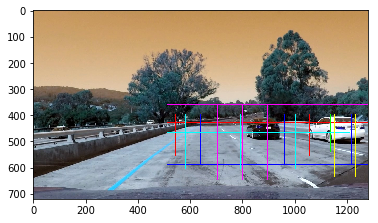

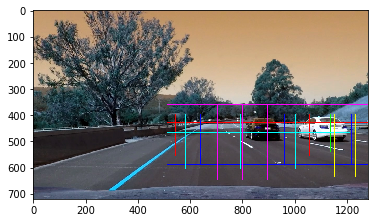

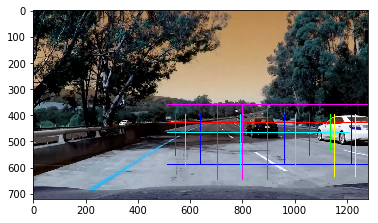

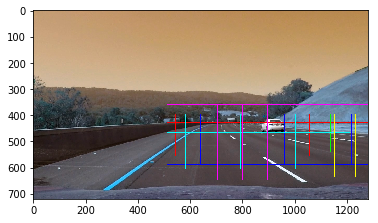

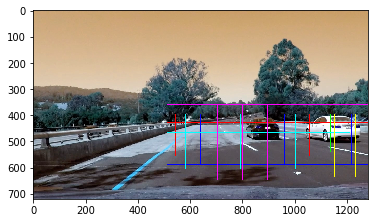

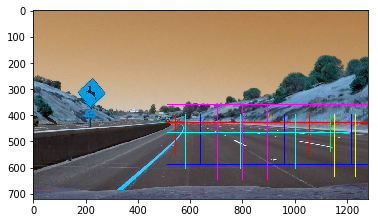

In [82]:
process = Process()
process.process_video()